In [3]:
pip install opencv-python numpy pillow

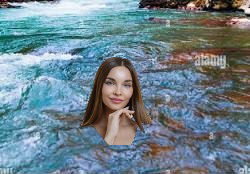

In [11]:
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

def remove_background_grabcut(foreground_path):
    # 1. Load foreground image using Pillow
    pil_img = Image.open(foreground_path).convert('RGB')
    img = np.array(pil_img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # 2. GrabCut Background Removal
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Define a rectangle around the object (x, y, width, height)
    # Adjust these values based on your specific foreground image
    height, width = img.shape[:2]
    rect = (10, 10, width-20, height-20)

    # Apply GrabCut
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Modify mask: 0 and 2 are background, 1 and 3 are foreground
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Create final foreground with transparency (RGBA)
    img_fg = img * mask2[:, :, np.newaxis]

    # Convert to RGBA to make background transparent
    tmp = cv2.cvtColor(img_fg, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(img_fg)
    rgba = [b, g, r, alpha]
    dst = cv2.merge(rgba, 4)

    return dst

def overlay_images(fg_image, bg_path, position=(50, 50), scale=1.0):
    # 3. Load background image
    background = cv2.imread(bg_path)

    # Resize foreground if needed
    if scale != 1.0:
        width = int(fg_image.shape[1] * scale)
        height = int(fg_image.shape[0] * scale)
        fg_image = cv2.resize(fg_image, (width, height))

    h, w = fg_image.shape[:2]
    x, y = position

    # Ensure overlay fits within background boundaries
    if y + h > background.shape[0] or x + w > background.shape[1]:
        print("Warning: Overlay exceeds background dimensions. Clipping...")
        h = min(h, background.shape[0] - y)
        w = min(w, background.shape[1] - x)
        fg_image = fg_image[:h, :w]

    # Extract alpha channel for blending
    overlay_img = fg_image[:, :, :3]
    overlay_mask = fg_image[:, :, 3:] / 255.0

    # 4. Overlay using OpenCV
    background[y:y+h, x:x+w] = (1.0 - overlay_mask) * background[y:y+h, x:x+w] + overlay_mask * overlay_img

    return background

# --- Execution ---
# Replace 'foreground.jpg' and 'background.jpg' with your file paths
fg_processed = remove_background_grabcut('foreground.jpg')
final_result = overlay_images(fg_processed, 'background.jpg', position=(50, 50), scale=0.5)

# 5. Display and Save
cv2_imshow(final_result)
cv2.imwrite('output_result.png', final_result)
cv2.waitKey(0)
cv2.destroyAllWindows()